# AUGMENTATION TRAINING

## Some interesting stuffs to do every time

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

E0000 00:00:1732017417.857111      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1119 11:56:57.865290377      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1119 11:56:57.865304193      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1119 11:56:57.865307462      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1119 11:56:57.865309842      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1119 11:56:57.865312098      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

2.16.1


In [3]:
# Import some other useful libraries or functions
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import keras_cv.layers as kcvl
from tensorflow.keras.utils import unpack_x_y_sample_weight

In [4]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [5]:
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

I0000 00:00:1732017481.360170      13 service.cc:145] XLA service 0x5cb036eb3540 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732017481.360232      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1732017481.360252      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1732017481.360255      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1732017481.360258      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1732017481.360261      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1732017481.360264      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1732017481.360267      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1732017481.360271      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


Running on TPU: 
Running on 8 replicas
Num GPUs Available:  0
Num TPUs Available:  8


In [6]:
data_path = "/kaggle/input/cleaned_training_set.npz"

In [7]:
data = np.load(data_path, allow_pickle=True)
lst = data.files
X = data[lst[0]]
y = data[lst[1]]

# Convert values in data to int
X = X.astype(int)

# Normalize data to the range [0, 1]
X = (X / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y = tf.keras.utils.to_categorical(y)

In [8]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.15, stratify=y)

del X, y

In [9]:
# Print the shapes of the loaded datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (10165, 96, 96, 3)
Training Label Shape: (10165, 8)
Validation Data Shape: (1794, 96, 96, 3)
Validation Label Shape: (1794, 8)


## Training section

We will use the ConvNeXtBase + TPU to speedup the training process.\

In [10]:
convnext = tf.keras.applications.ConvNeXtBase(
    include_top=False,
    weights='imagenet',
    input_shape=(96,96,3),
)

convnext.trainable = False

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Now let's write a complex augmentation pipeline, this will include:\
**1.** ChannelShuffle\
**2.** RandAugment\
**3.** AugMix\
**4.** GridMask\
**5.** RandomFlip

In [11]:
with strategy.scope():
    img_augmentation = tf.keras.Sequential(
        [
        kcvl.ChannelShuffle(groups=3),
        kcvl.AugMix(
            severity=0.75,
            value_range=(0, 255),
            alpha=1.0
        ),
        kcvl.GridMask(ratio_factor=(0, 0.5), rotation_factor=0.15, fill_mode='constant', fill_value=0.0),
        kcvl.RandAugment(
            value_range = (0,1),
            augmentations_per_image=8,
            magnitude=0.3,
            magnitude_stddev=0.15,
            rate=0.9090909090909091,
            geometric=True,
            seed=seed
        ),
        tfkl.RandomFlip()
        ],
        name="img_augmentation")

I0000 00:00:1732017537.613658      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [12]:
from keras.utils import register_keras_serializable

@register_keras_serializable()
class CustomCastLayer(tfk.layers.Layer):
    def call(self, inputs):
        return tf.cast(inputs * 255, tf.uint8)

In [21]:
def create_model(input_shape=(96, 96, 3)):
    """
        Build a CNN with Tranfer Learning from ConvNeXtBase re-adapt to eight class classification.
        Augmentations: CastLayer
        FC layers block:
            Batch Normalization -> Dense (activation = swish) -> Dropout (0.5)
        Compile options:
            LOSS: CategoricalFocalCrossentropy
            METRICS: Accuracy
            OPTIMIZER: AdamW with standard parameters
    """
    tf.random.set_seed(seed)
    inputs = tfk.Input(shape=input_shape)

    # Cast input
    x = CustomCastLayer()(inputs)

    x = convnext(x)
    x = tfkl.GlobalAveragePooling2D(name="avg_pool")(x)
    x = tfkl.BatchNormalization(name="batch_normalization_0")(x)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    x = tfkl.Dense(1024, activation=tf.keras.activations.swish, name='dense_layer_0')(x)
    x = tfkl.Dropout(0.5)(x)
    x = tfkl.BatchNormalization(name="batch_normalization_1")(x)
    x = tfkl.Dropout(0.5)(x)
    x = tfkl.Dense(512, activation=tf.keras.activations.swish, name='dense_layer_1')(x)
    x = tfkl.Dropout(0.5)(x)
    x = tfkl.BatchNormalization(name="batch_normalization_2")(x)

    outputs = tfkl.Dense(8, activation='softmax')(x)

    # Create a Model connecting input and output
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    optimizer = tf.keras.optimizers.AdamW()
    loss = tfk.losses.CategoricalFocalCrossentropy( alpha=0.25,
                                                    gamma=2.0,
                                                    from_logits=False,
                                                    label_smoothing=0.0,
                                                    axis=-1,
                                                    reduction="sum_over_batch_size",
                                                    name="categorical_focal_crossentropy",
                                                )
    METRICS = [tfk.metrics.CategoricalAccuracy()]
    model.compile(loss=loss, optimizer=optimizer, metrics=METRICS)

    # Return the model
    return model

In [15]:
from keras.callbacks import Callback
import IPython.display as display

class RealTimePlot(Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['categorical_accuracy'])
        self.val_acc.append(logs['val_categorical_accuracy'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Accuracy')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        self.ax_acc.set_title('Training and Validation Accuracy')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Accuracy')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

In [16]:
class CustomReduceLROnPlateau(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_categorical_accuracy', factor=0.2, patience=5, min_lr=1e-6, verbose=1):
        super(CustomReduceLROnPlateau, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.new_lr = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        
        # Initialize best metric if it's the first epoch
        if self.best is None:
            self.best = current
            return

        # Check if the monitored metric has improved
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1

            # If patience is exceeded, reduce the learning rate
            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                self.new_lr = max(old_lr * self.factor, self.min_lr)
                self.model.optimizer.learning_rate.assign(self.new_lr)
                
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: reducing learning rate to {self.new_lr}.")
                
                self.wait = 0  # Reset patience counter

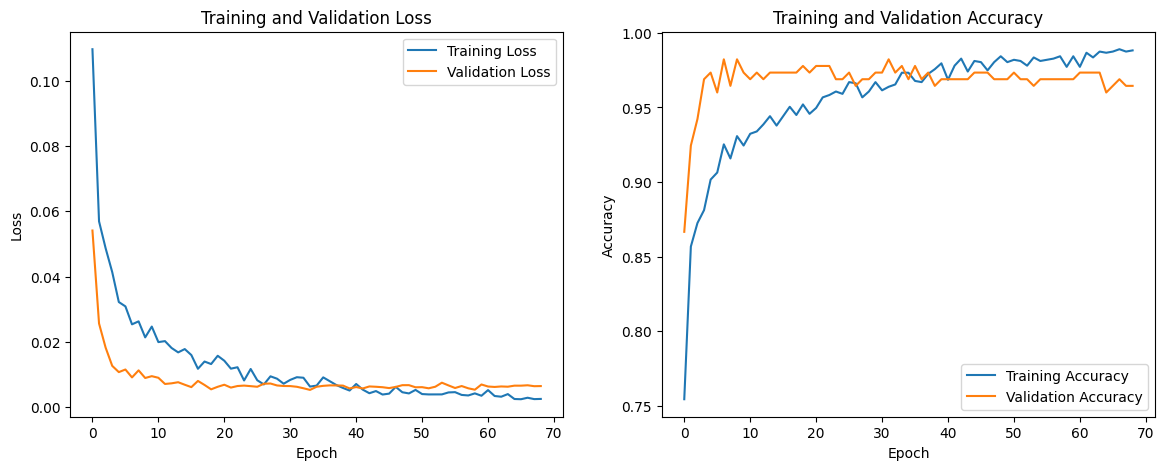

80/80 ━━━━━━━━━━━━━━━━━━━━ 32s 390ms/step - categorical_accuracy: 0.9896 - loss: 0.0024 - val_categorical_accuracy: 0.9644 - val_loss: 0.0064


In [22]:
# Build a ConvNeXtBase model for transfer learning
with strategy.scope():
    model = create_model()
    
lr_reducer = CustomReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-8)
plot_callback = RealTimePlot()

callbacks = [lr_reducer, plot_callback, tfk.callbacks.EarlyStopping(monitor='val_loss',
                                             mode='min',
                                             patience=35,
                                             restore_best_weights=True)]

history = model.fit(
    x = X_train, 
    y = y_train,  
    batch_size = 128,
    epochs = 350,
    validation_data = (X_val, y_val), 
    callbacks = callbacks
).history

In [23]:
model_path = '/kaggle/working/model1.keras'

# Save the trained ConvNeXt model with transfer learning
model.save(model_path)

print("Finished training of ", model_path, " model. Model saved successfully.")

Finished training of  /kaggle/working/model1.keras  model. Model saved successfully.


In [22]:
val_loss = []
val_accuracy = []
train_loss = []
train_accuracy = []

last_val_loss, last_val_accuracy = model.evaluate(X_val, y_val)
last_train_loss, last_train_accuracy = model.evaluate(X_train, y_train)

val_loss.append(last_val_loss)
val_accuracy.append(last_val_accuracy)
train_loss.append(last_train_loss)
train_accuracy.append(last_train_accuracy)

print("Last model evaluation:")
print("Train loss:", last_train_loss)
print("Train accuracy:", last_train_accuracy)
print("Validation loss:", last_val_loss)
print("Validation accuracy:", last_val_accuracy)

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9777 - loss: 0.0077
318/318 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.9983 - loss: 5.3705e-04
Last model evaluation:
Train loss: 0.0006121911574155092
Train accuracy: 0.9977373480796814
Validation loss: 0.007835179567337036
Validation accuracy: 0.9743589758872986


In [24]:
# Get the weights of the last two dense layers and the output layer
batch_norm_0_weights = model.get_layer('batch_normalization_0').get_weights()
dense_layer_0_weights = model.get_layer('dense_layer_0').get_weights()
batch_norm_1_weights = model.get_layer('batch_normalization_1').get_weights()
dense_layer_1_weights = model.get_layer('dense_layer_1').get_weights()
batch_norm_2_weights = model.get_layer('batch_normalization_2').get_weights()
output_layer_weights = model.get_layer('dense').get_weights()

# Save the weights to files
np.savez('batch_norm_0_weights.npz', *batch_norm_0_weights)
np.savez('dense_layer_0_weights.npz', *dense_layer_0_weights)
np.savez('batch_norm_1_weights.npz', *batch_norm_1_weights)
np.savez('dense_layer_1_weights.npz', *dense_layer_1_weights)
np.savez('batch_norm_2_weights.npz', *batch_norm_2_weights)
np.savez('output_layer_weights.npz', *output_layer_weights)

# Conclusion

As demonstrated, we achieved very good accuracy on the validation set. However, our model only achieved 0.81 accuracy on Codabench, indicating the need for further improvement. Currently, we are using ConvNeXtBase instead of ConvNeXtXLarge, and Fine-Tuning has not yet been applied.

Incorporating these two elements (ConvNeXtXLarge + Fine-Tuning) would significantly increase our training time, from approximately 45 ± 7 seconds per epoch to more than 5 minutes per epoch. For instance, training 100 epochs with our current setup takes around 1 hour 15 minutes, whereas with ConvNeXtXLarge and Fine-Tuning, it would take approximately 8 hours 20 minutes.

To address this challenge and optimize training time, we decided to apply augmentation directly to the dataset and remove the augmentation layers from the network.

With this setup in place, we can now move forward by applying stronger augmentation techniques in combination with Fine-Tuning on ConvNeXtXLarge.